This notebook is for code illustration only. The model used in the demo is hardly trained thus the segmentation power is very low.

In [1]:
import torch, torchvision
print(torch.__version__)
print(torch.cuda.is_available())

1.7.1
False


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

In [2]:
# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine.defaults import DefaultPredictor

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 15)

In [5]:
# custom utilities
import sys
sys.path.append('../src')

from config import ProjConfig
from data_utils import register_isaid_truck_data
from model_eval import setup_eval_config, predict_single_image

In [6]:
def imshow(image):
    """shows a BGR image"""
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [7]:
proj_config = ProjConfig()
_ = register_isaid_truck_data(extra_meta={}, register_val=False, register_test=True)

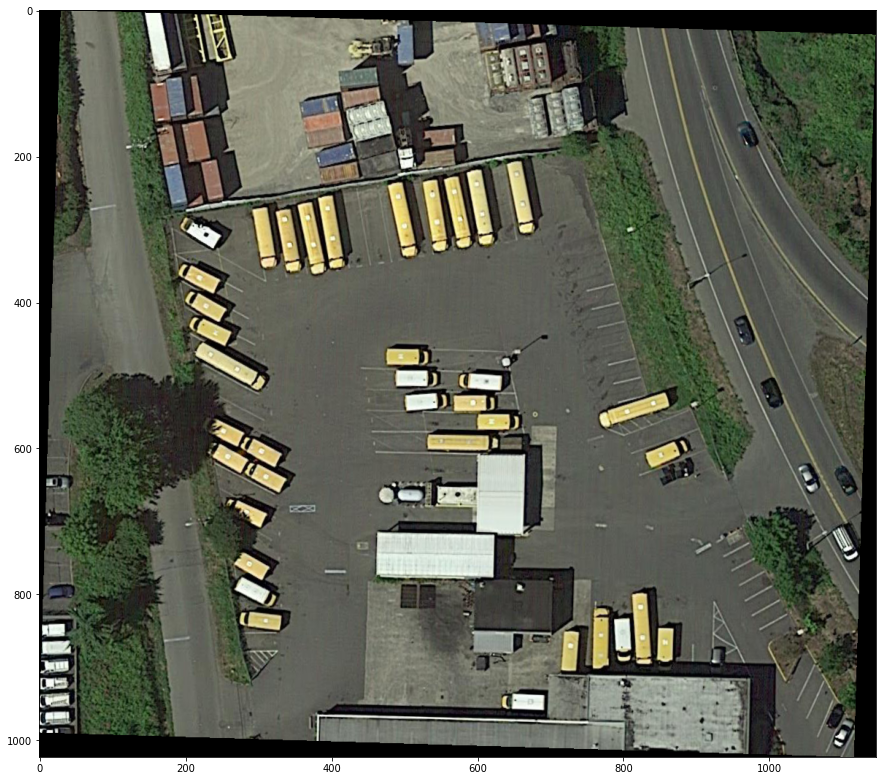

In [8]:
test_image_path = os.path.join(proj_config.train_image_path, 'P0003.png')
test_image = cv2.imread(test_image_path)
# !wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
# coco_image = cv2.imread("./input.jpg")
imshow(test_image)

In [10]:
class Args():
    model_path = '../models/detectron_20210401155414_freeze2_batchsize2_lr0.00025/model_0000009.pth'
    distributed = False
    output_dir = '../models/detectron_20210401155414_freeze2_batchsize2_lr0.00025/inference/'

In [11]:
args = Args()
cfg = setup_eval_config(args.model_path, proj_config.test_data_name)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# model
model = build_model(cfg)
checkpointer = DetectionCheckpointer(model)
_ = checkpointer.load(cfg.MODEL.WEIGHTS)
# predictor
predictor = DefaultPredictor(cfg)

In [12]:
outputs = predictor(test_image)

/Users/guangmingliu/miniconda3/envs/torch/lib/python3.6/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370253951/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


In [13]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Boxes(tensor([[3.4374e+02, 6.5313e+02, 8.4686e+02, 8.5437e+02],
        [1.2959e+02, 7.6668e+00, 2.5330e+02, 1.4213e+02],
        [1.7718e+02, 2.5118e-01, 2.3245e+02, 1.1110e+02],
        [4.6387e+02, 7.3133e+02, 7.6005e+02, 8.2057e+02],
        [4.2328e+02, 5.6425e+02, 6.8806e+02, 6.6514e+02],
        [1.6604e+02, 4.3185e-01, 2.7928e+02, 2.0552e+02],
        [4.3667e+02, 6.8463e+02, 9.5227e+02, 9.1539e+02],
        [4.0734e+02, 5.6369e+02, 7.2204e+02, 8.5972e+02],
        [1.9606e+02, 6.2049e+00, 2.6180e+02, 7.6333e+01],
        [1.9492e+02, 6.6088e+01, 2.6344e+02, 1.4047e+02],
        [1.9281e+02, 5.9409e+00, 2.2730e+02, 8.1483e+01],
        [1.5205

In [14]:
MetadataCatalog.get(cfg.DATASETS.TEST[0])

namespace(name='isaid_truck_val',
          json_file='/Users/guangmingliu/Work/cv_obj_detection_demo/data/iSAID/val/truck/val_anno.json',
          image_root='/Users/guangmingliu/Work/cv_obj_detection_demo/data/iSAID/val/truck/val',
          evaluator_type='coco')

In [15]:
v = Visualizer(test_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

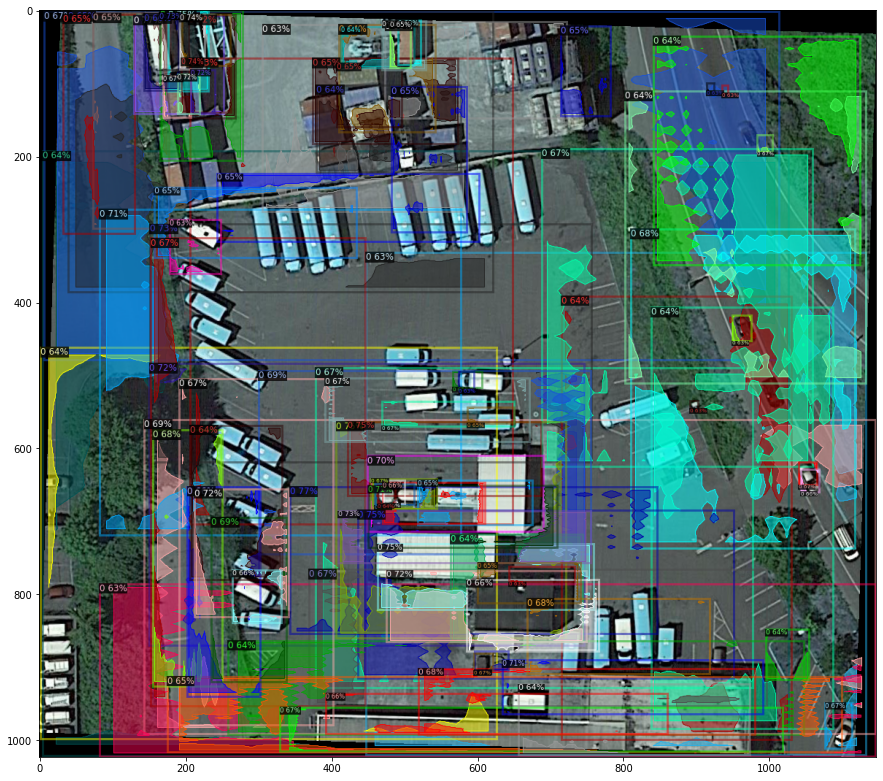

In [16]:
imshow(out.get_image())

#### Using a Pretrained Model and Illustrating with COCO data

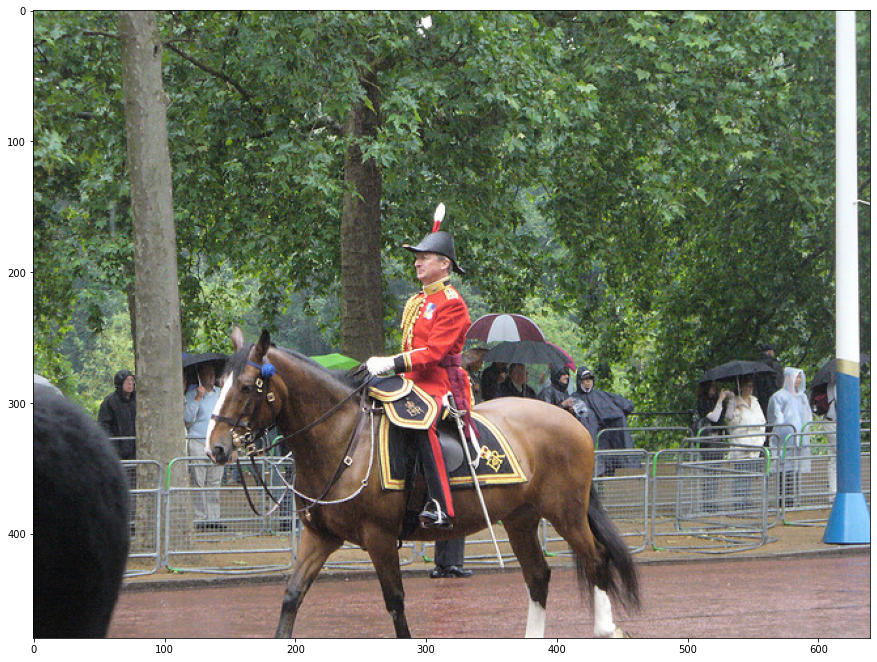

In [17]:
# !wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
coco_image = cv2.imread("./input.jpg")
imshow(coco_image)

In [18]:
coco_cfg = get_cfg()
coco_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
coco_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
coco_cfg.MODEL.DEVICE = 'cpu'

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
coco_cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(coco_cfg)

In [19]:
outputs = predictor(coco_image)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24])
Boxes(tensor([[126.6049, 244.8985, 459.8287, 480.0000],
        [251.1093, 157.8128, 338.9732, 413.6367],
        [114.8497, 268.6858, 148.2354, 398.8107],
        [  0.8217, 281.0327,  78.6073, 478.4209],
        [ 49.3954, 274.1232,  80.1549, 342.9802],
        [561.2246, 271.5818, 596.2748, 385.2532],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9296, 278.3742, 562.2794, 389.3802],
        [335.2410, 251.9167, 414.7491, 275.9375],
        [350.9302, 269.2061, 386.0984, 297.9080],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2655, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5583, 356.8722],
        [506.8766, 283.3257, 529.9404, 324.0391],
        [594.5659, 283.4807, 609.0584, 311.4129]]))


In [23]:
v = Visualizer(coco_image[:, :, ::-1], MetadataCatalog.get(coco_cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

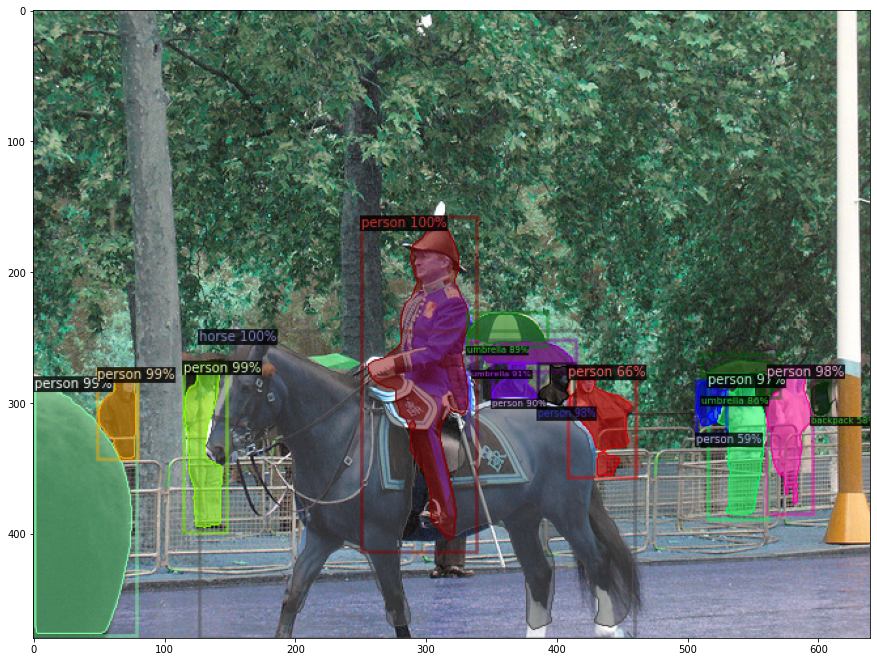

In [24]:
imshow(out.get_image())

In [25]:
def compare_input_output(image_input, image_output):
    f, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0,].imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
    ax[0,].set_title("Input")
    ax[1,].imshow(cv2.cvtColor(image_output, cv2.COLOR_BGR2RGB))
    ax[1,].set_title("Segmented")
    plt.show()

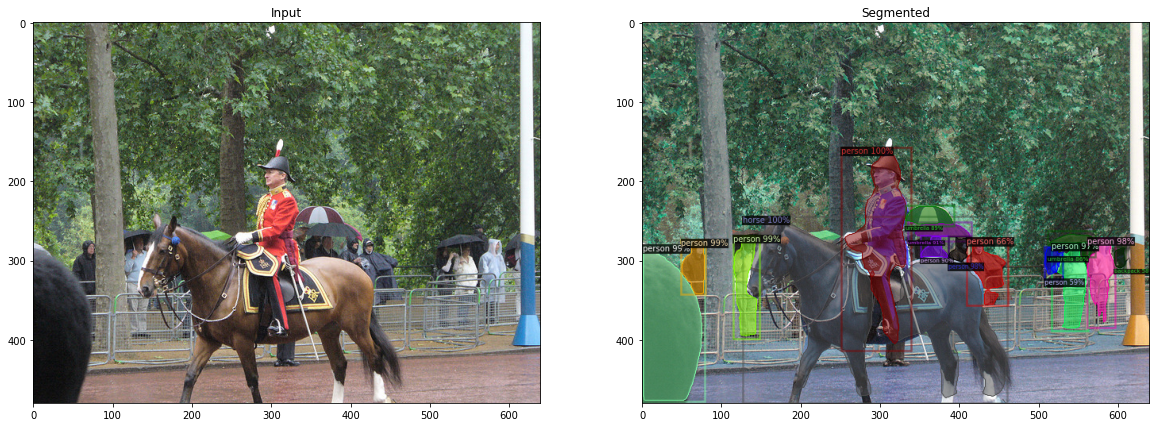

In [26]:
compare_input_output(coco_image, out.get_image())